In [2]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [3]:
import compressai
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
net = compressai.zoo.cheng2020_attn(6, "mse", pretrained=True)

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-6-730501f2.pth.tar" to /home/xyhang/.cache/torch/hub/checkpoints/cheng2020_attn-mse-6-730501f2.pth.tar
100%|██████████| 121M/121M [00:47<00:00, 2.70MB/s] 


In [5]:
class RateDistortionLoss(nn.Module):
    """Custom rate distortion loss with a Lagrangian parameter."""

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target, lmbda):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W

        likelihoods = output['likelihoods']
        bits_y = -torch.log2(likelihoods['y'])
        bits_z = -torch.log2(likelihoods['z']) if 'z' in likelihoods else torch.tensor(0.)

        out['bpp_y_loss'] = torch.sum(bits_y) / num_pixels
        out['bpp_z_loss'] = torch.sum(bits_z) / num_pixels
        out['bpp_loss'] = out['bpp_y_loss'] + out["bpp_z_loss"]

        out["mse_loss"] = torch.mean((output["x_hat"] - target) ** 2, dim=(1, 2, 3))
        dloss = 255**2 * torch.mean(torch.mul(lmbda, out["mse_loss"]))
        out["mse_loss"] = torch.mean(out["mse_loss"])
        out["loss"] = dloss + out["bpp_loss"]
        out["psnr_loss"] = -10 * torch.log10(out["mse_loss"])

        return out

In [6]:
input

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7f5a145787f0>>

In [11]:
import math

def normalize_l2(x, delta):
    mx = x.square().mean()
    if mx > 0.:
        mx2 = torch.minimum(mx, torch.tensor(delta))
        x = x * (mx2 / mx).sqrt()
    return x

def normalize_l0(x, delta):
    x = x.clamp(torch.tensor(-delta,device=x.device), torch.tensor(delta,device=x.device))
    return x

def cosine_decay(init_lr, step, num_steps, alpha):
    t = step / num_steps
    a = (1. + math.cos(t * math.pi)) * init_lr / 2
    return alpha * init_lr + (1-alpha) * a


def find_image(net, img, num_steps=100, init_lr=1e-3, delta=.01):
    img = img.detach().cuda()
    # input = nn.Parameter(img.clone().detach().unsqueeze(0))
    noise = nn.Parameter(delta*(torch.rand_like(img)-0.5).unsqueeze(0))
    # print(input)
    net = net.cuda()
    optimizer = torch.optim.Adam([noise], init_lr)
    net.train()
    criterion = RateDistortionLoss()
    for i in range(num_steps):
        optimizer.param_groups[0]['lr'] = cosine_decay(init_lr, i, num_steps, 0.01)

        noise_normed = normalize_l0(noise, delta)
        input2 = torch.clamp(noise_normed + img.unsqueeze(0), 0., 1.)
        out = net(input2)
        out["x_hat"] = torch.clamp(out["x_hat"], 0., 1.)
        out_criterion = criterion(out, input2, 0.05)
        loss_rd = - out_criterion['loss']
        loss = loss_rd

        if i % 10 == 0:
            print(f"Step: {i} "
              f"Loss: {loss.detach().cpu()} "
              f"PSNR_rd: {out_criterion['psnr_loss'].detach().cpu()} " 
              f"BPP_rd: {out_criterion['bpp_loss'].detach().cpu()} ")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    noise_normed = normalize_l0(noise, delta)
    output = (noise_normed[0] + img).clamp(0., 1.).detach().cpu()
    output = torch.round(output * 255) / 255.
    return output

In [12]:
from dataset import Kodak
ds = Kodak()
img = ds[1]

In [13]:
att = find_image(net, img)

Step: 0 Loss: -1.2660022974014282 PSNR_rd: 37.24091339111328 BPP_rd: 0.652297854423523 
Step: 10 Loss: -1.806821584701538 PSNR_rd: 35.04019546508789 BPP_rd: 0.7881581783294678 
Step: 20 Loss: -1.9879151582717896 PSNR_rd: 34.48173522949219 BPP_rd: 0.8294659852981567 
Step: 30 Loss: -2.029878854751587 PSNR_rd: 34.33815383911133 BPP_rd: 0.8324904441833496 
Step: 40 Loss: -2.0465786457061768 PSNR_rd: 34.273658752441406 BPP_rd: 0.8312754034996033 
Step: 50 Loss: -2.052276849746704 PSNR_rd: 34.248504638671875 BPP_rd: 0.8299145698547363 
Step: 60 Loss: -2.056215286254883 PSNR_rd: 34.23564147949219 BPP_rd: 0.8302268385887146 
Step: 70 Loss: -2.063765525817871 PSNR_rd: 34.2133903503418 BPP_rd: 0.8314797878265381 
Step: 80 Loss: -2.059420585632324 PSNR_rd: 34.22264099121094 BPP_rd: 0.8297566175460815 
Step: 90 Loss: -2.0579257011413574 PSNR_rd: 34.23632049560547 BPP_rd: 0.8321285247802734 


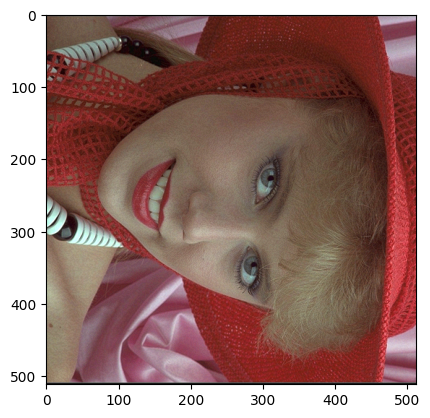

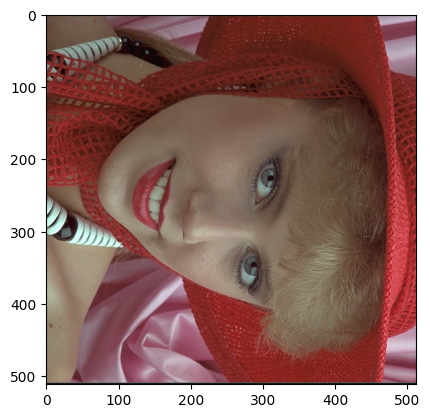

In [14]:
plt.imshow(att.clamp(0., 1.).detach().cpu().permute(1, 2, 0))
plt.show()
plt.imshow(img.detach().cpu().permute(1, 2, 0))

In [15]:
mse = torch.mean((att.clamp(0, 1) - img)**2)
psnr = -10*torch.log10(mse)
print(f"MSE: {mse:.8f}", mse, "PSNR: att-img", psnr)

MSE: 0.00013619 tensor(0.0001) PSNR: att-img tensor(38.6585)


In [16]:
def get_recon_bpp(net: nn.Module, img, training=False):
    net.train(training).cuda()
    input = img.cuda().unsqueeze(0).clamp(0., 1.)
    out_net = net(input)
    out_net['x_hat'] = out_net['x_hat'].clamp(0., 1.)
    recon_img = out_net['x_hat'].detach().cpu()[0]
    criterion = RateDistortionLoss()
    out_criterion = criterion(out_net, input, 0)
    bpp = out_criterion['bpp_loss'].detach().cpu()
    psnr = out_criterion['psnr_loss'].detach().cpu()
    return recon_img, bpp, psnr

In [17]:
recon_img, bpp_img, psnr_img = get_recon_bpp(net, img, False)
recon_att, bpp_att, psnr_att = get_recon_bpp(net, att, False)

In [18]:
print(bpp_img, bpp_att)
print(psnr_img, psnr_att)

tensor(0.5413) tensor(0.7838)
tensor(37.1806) tensor(33.5691)


In [19]:
torch.mean((att - recon_att) ** 2)

tensor(0.0004)

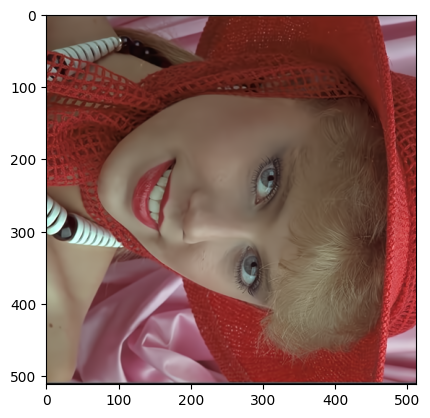

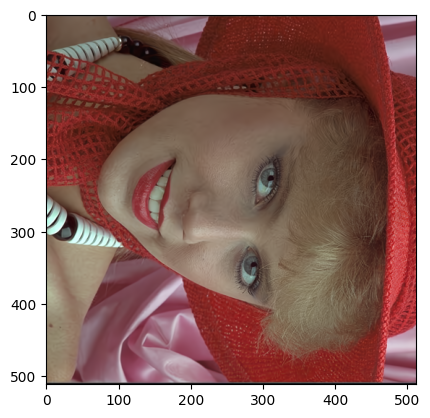

In [20]:
plt.imshow(recon_img.permute(1,2,0))
plt.show()
plt.imshow(recon_att.permute(1,2,0))

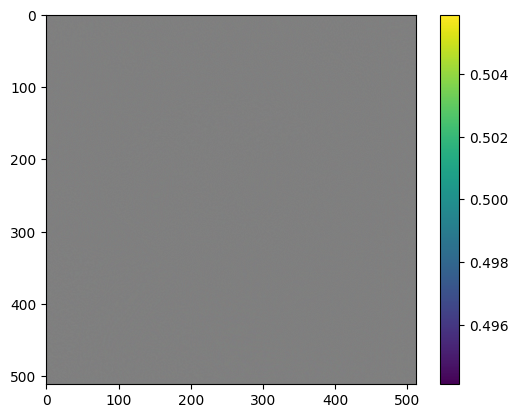

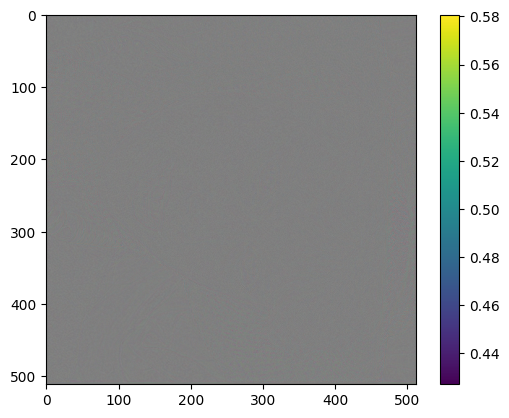

In [27]:
plt.imshow(0.5*(att - img + 1.).permute(1,2,0))
plt.colorbar()
plt.show()
plt.imshow(0.5*(att - recon_att + 1.).permute(1,2,0))
plt.colorbar()

In [22]:
net2 = compressai.zoo.bmshj2018_factorized(6, "mse", pretrained=True)

tensor(0.7153) tensor(0.8860)
tensor(36.5132) tensor(33.4541)


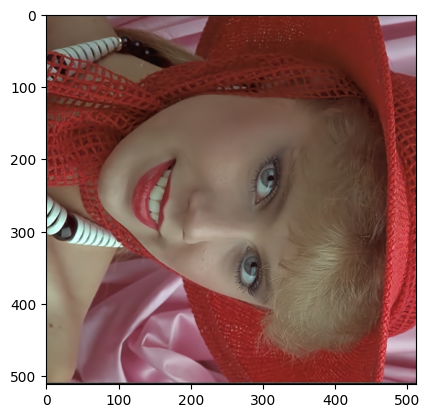

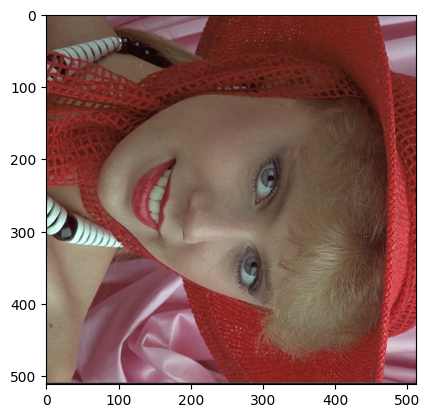

In [23]:
recon_img2, bpp_img2, psnr_img2 = get_recon_bpp(net2, img)
recon_att2, bpp_att2, psnr_att2 = get_recon_bpp(net2, att)
print(bpp_img2, bpp_att2)
print(psnr_img2, psnr_att2)
plt.imshow(recon_img2.permute(1,2,0))
plt.show()
plt.imshow(recon_att2.permute(1,2,0))

In [24]:
# View feature map

def get_bpp_map(net: nn.Module, img, training=False):
    net.train(training).cuda()
    input = img.cuda().unsqueeze(0).clamp(0., 1.)
    out_net = net(input)
    return out_net['likelihoods']['y'][0]

y_prob = get_bpp_map(net, img)
y_prob_att = get_bpp_map(net, att)

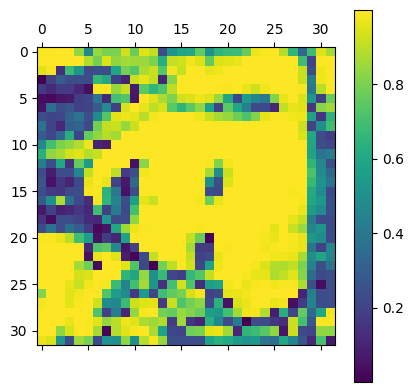

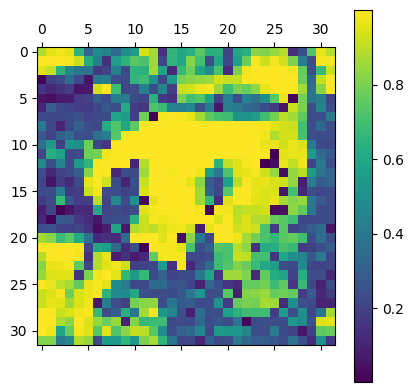

In [25]:
def show_tensor(x, c):
    plt.matshow(x[c].detach().cpu().numpy())
    plt.colorbar()
    plt.show()
    plt.close()

show_tensor(y_prob, 0)
show_tensor(y_prob_att, 0)

In [28]:
y_prob.mean()

tensor(0.7709, device='cuda:0', grad_fn=<MeanBackward0>)

In [29]:
y_prob_att.mean()

tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)